<a href="https://colab.research.google.com/github/natskiu/Nasa-Battery/blob/main/Data_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and feature extraction

In this notebook, we import and process the raw experimental data to extract the required features. We then store these into a Pandas dataframe which can be exported to a csv file for future use.

## Importing libraries and loading data

In [9]:
import numpy as np
import matplotlib.pyplot as plt
#this is a comment
import scipy.io as sio
import pandas as pd
import modules.utils as tools


In [10]:
import importlib
tools = importlib.reload(tools)

In [11]:
# raw=true is important so you download the file rather than the webpage.
#!wget https://github.com/natskiu/Nasa-Battery/blob/main/Data/B0005.mat?raw=true
# rename the file - we are importing the data for one battery, B0005.
#!mv B0005.mat\?raw\=true B0005.mat
# update scipy
#!pip install -U -q scipy
# Load the data
from scipy import io
import os
datapath = 'Data/'
v = io.loadmat(datapath + 'B0005.mat')

## Preprocessing raw data

### Raw data structure 
The raw battery data was stored as one big numpy array in a nested dictionary under the key that corresponds to its battery id (e.g. B0005). The array contains all the information regarding charing cycles, discharging cycles and impedance. After some data wrangling each charging cycle, discharging cycle and impedance could be separated to an indexable entry. We discovered that the impedance information was recorded at irregular intervals, we decided not to incorporate it to our model. 

Each charging/ discharging cycle contains information listed below:
1. voltage of the battery measured over the cycle
2. current of the battery measured over the cycle
3. temperature measured over the cycle
4. current at the load measured over the cycle
5. voltage at the load measured over the cycle
6. time over the cycle
7. capacity (only measured once per cycle)

In [4]:
type(v)

dict

In [6]:
v.keys()

dict_keys(['__header__', '__version__', '__globals__', 'B0005'])

In [12]:
# This extracts the data for all cycles in the form of a nested numpy array.
raw_cycles = np.vstack(v['B0005'][0,0])
type(raw_cycles)

numpy.ndarray

In [6]:
raw_cycles.shape

(1, 616)

In [7]:
# the middle index indicates the charge/discharge number. 
# For example, cycles[0,0][3] gets the data for the first charge, cycles[0,1][3] gets the data for the first discharge, etc.
raw_cycles[0,0][3].shape

(1, 1)

In [13]:
discharge_indices = tools.get_indices(raw_cycles, is_charge = False)
discharge_indices = discharge_indices
#discharge_indices.remove(8)
#discharge_indices.pop()
print(discharge_indices)
len(discharge_indices)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 135, 139, 143, 147, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 215, 219, 223, 227, 231, 235, 239, 243, 247, 251, 255, 259, 263, 265, 269, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309, 312, 315, 319, 323, 327, 331, 335, 339, 343, 347, 351, 355, 359, 363, 366, 370, 374, 378, 382, 386, 390, 394, 398, 402, 406, 410, 414, 418, 422, 426, 430, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 482, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 547, 551, 555, 559, 563, 567, 571, 575, 579, 583, 587, 591, 595, 599, 603, 607, 611, 613]


168

In [9]:
charge_indices = tools.get_indices(raw_cycles, is_charge=True)
# manually look through the repeated charge cycle
#charge_indices.remove(9)
#charge_indices.remove(41)
print(charge_indices)
len(charge_indices)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 31, 33, 35, 37, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 84, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127, 131, 134, 137, 141, 145, 148, 151, 155, 159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 199, 203, 207, 211, 214, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253, 257, 261, 264, 267, 271, 275, 279, 283, 287, 291, 295, 299, 303, 307, 314, 317, 321, 325, 329, 333, 337, 341, 345, 349, 353, 357, 361, 365, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 431, 434, 438, 442, 446, 450, 454, 458, 462, 466, 470, 474, 478, 481, 483, 486, 490, 494, 498, 502, 506, 510, 514, 518, 522, 526, 530, 534, 538, 542, 546, 549, 553, 557, 561, 565, 569, 573, 577, 581, 585, 589, 593, 597, 601, 605, 609, 612, 615]


170

In [9]:
"This is how you extract all the features from cycles"
#np.vstack(cycles[0,0][3][0,0])[0]

'This is how you extract all the features from cycles'

In [14]:
new_cycles = tools.capacity_vectorizer(discharge_indices, raw_cycles)

In [11]:
new_cycles.shape

(1, 616)

In [13]:
new_cycles[0,1][3][0,0][6].shape

(197,)

In [21]:
# getting the time series data of voltage_measured, temperature and time

def get_time_series(discharge_indices, discharge_index):
    '''
    discharge_index: 

    '''
    time = new_cycles[0,discharge_index][3][0,0][5].flatten().tolist()
    voltage_measured = new_cycles[0,discharge_index][3][0,0][0].flatten().tolist()
    temperature = new_cycles[0,discharge_index][3][0,0][2].flatten().tolist()
    ts_dict = {'time':time, 'voltage_measured': voltage_measured, 'temperature': temperature}
    cycle_number = discharge_indices.index(discharge_index)
    dataframe = pd.DataFrame(ts_dict)
    dataframe['cycle number'] =  cycle_number
    return dataframe


In [23]:
dataframes_B0005 = []
for discharge_index in discharge_indices:
    dataframes_B0005.append(get_time_series(discharge_indices, discharge_index))


In [19]:
import joblib

In [24]:
dataframe_all_B0005=pd.concat(dataframes_B0005, axis=0)
len(dataframe_all_B0005)
joblib.dump(dataframe_all_B0005, 'df_timeseries_B0005')

['df_timeseries_B0005']

In [ ]:
for discharge_index in discharge_indices:
    times = new_cycles[0,discharge_index][3][0,0][5].flatten().tolist()
    print(times[-1], discharge_index)


In [ ]:
for charge_index in charge_indices:
    times = new_cycles[0,charge_index][3][0,0][5].flatten().tolist()
    print(times[-1], charge_index)


In [27]:
len(discharge_indices)

102

### Visualising the raw battery data

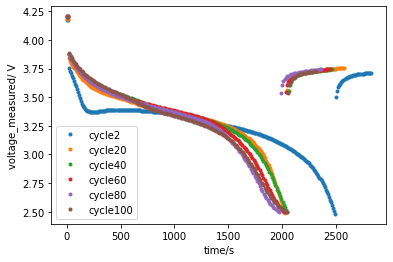

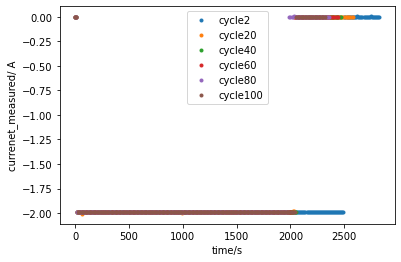

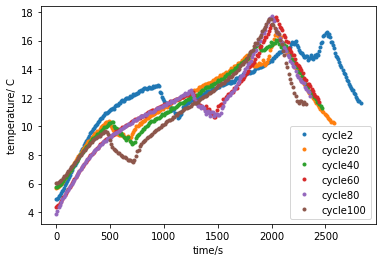

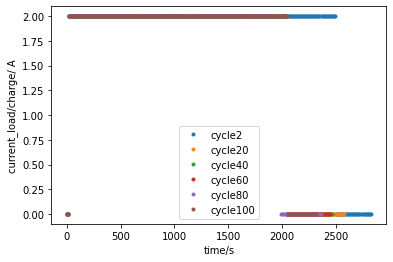

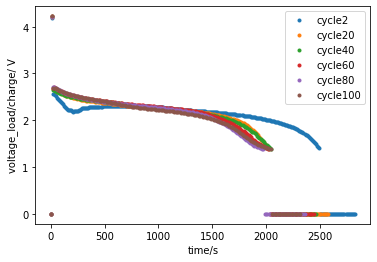

In [28]:
tools.cycle_plotter(new_cycles, discharge_indices, [2,20,40,60,80,100])

## Feature extration from original dataset

### Features
#### Discharging cycle

1. Time taken for discharging temperature to reach max value (set threshold ~ 1000s)
2. Max. temperature during discharge
3. Slope for temperature during discharge 
(max_temp - initial_temp)/(time_at_max_temp)
4. Time for voltage_measured to drop below 3 Volts
5. Slope for first 20 data points of voltage_measured

#### Charging cycle

6. Time  taken for charging temperature to reach max value (set threshold ~ 1000s)
7. Max. temperature during charge

### Label
* Capacity recorded for each discharging cycle


## Data Exploration

In [372]:
import importlib
tools = importlib.reload(tools)

In [13]:
feature_1_list, feature_2_list = tools.extract_feature_1_2_6_7(discharge_indices, new_cycles, l_threshold=10, r_threshold=1200, peak_width=3)
feature_6_list, feature_7_list = tools.extract_feature_1_2_6_7(charge_indices, new_cycles, l_threshold=100, r_threshold=1500)
feature_3_list = tools.extract_feature_3(discharge_indices, new_cycles, l_threshold=10, r_threshold=1200, peak_width=3)
feature_4_list = tools.extract_feature_4(new_cycles, discharge_indices)
feature_5_list = tools.extract_feature_5(new_cycles, discharge_indices)
label_list = tools.extract_label(new_cycles, discharge_indices)
remaining_cycles_list = tools.remaining_cycles(new_cycles, discharge_indices, threshold=0.7)

In [14]:
features_dict = {'time_for_max_temp_D':feature_1_list,'max_temp_D':feature_2_list,
                 'slope_temp_D': feature_3_list, 'time_voltage_measured_below3_D':feature_4_list,
                 'slope_voltage_measured_D':feature_5_list, 'time_for_max_temp_C':feature_6_list,
                 'max_temp_C':feature_7_list, 'capacity': label_list, 'remaining_cycles': remaining_cycles_list}

In [15]:
df = pd.DataFrame(data = features_dict)
df

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
0,949.890,25.129608,0.001281,1731.609,-0.000167,147.953,25.950509,1.001983,196
1,1089.562,26.200155,0.001212,3171.859,-0.000343,107.437,25.530575,1.801101,195
2,503.344,25.541194,0.001986,3176.516,-0.000351,117.157,25.244305,1.804423,194
3,1039.781,25.994154,0.001707,3174.562,-0.000354,119.813,24.993689,1.804389,193
4,268.828,24.656908,0.002412,3163.281,-0.000355,105.844,24.774569,1.798925,192
...,...,...,...,...,...,...,...,...,...
192,NaN,NaN,NaN,2817.938,-0.000405,116.328,36.026231,1.596985,4
193,NaN,NaN,NaN,2800.266,-0.000410,116.953,36.144390,1.595726,3
194,NaN,NaN,NaN,2770.344,-0.000416,116.829,35.090194,1.579500,2
195,NaN,NaN,NaN,2740.656,-0.000421,117.219,34.366224,1.562947,1


In [64]:
filepath = 'processed_csv/'
name = 'B0056_processed.csv'
df.to_csv(filepath+name)

In [16]:
df.describe()

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
count,18.000000,18.000000,18.000000,197.000000,197.000000,156.000000,156.000000,197.000000,197.000000
mean,726.890500,25.716050,0.001755,2996.493594,-0.000385,114.051603,33.060563,1.699463,98.000000
std,270.978286,2.186957,0.001070,178.113978,0.000027,26.023938,3.278152,0.097134,57.013156
min,241.515000,24.255023,0.000936,1731.609000,-0.000422,103.437000,24.072864,1.001983,0.000000
25%,526.379000,24.775175,0.001283,2904.578000,-0.000404,107.531500,33.407312,1.651179,49.000000
50%,724.554500,25.073615,0.001479,2989.344000,-0.000390,110.070000,33.984916,1.694404,98.000000
75%,948.257500,25.861300,0.001689,3103.109000,-0.000369,112.879500,34.737915,1.753614,147.000000
max,1109.547000,33.990145,0.005795,4340.234000,-0.000167,410.141000,36.613107,2.444062,196.000000


In [17]:
corr_matrix = df.corr()
corr_matrix

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
time_for_max_temp_D,1.000000,0.468075,0.118977,-0.110037,0.230865,0.286990,0.118486,-0.117740,-0.289565
max_temp_D,0.468075,1.000000,0.857365,0.309162,-0.040882,-0.080304,0.828637,0.295450,-0.784871
slope_temp_D,0.118977,0.857365,1.000000,0.353588,-0.120424,-0.441449,-0.180630,0.343763,-0.660100
time_voltage_measured_below3_D,-0.110037,0.309162,0.353588,1.000000,0.357928,-0.000163,-0.240006,0.999003,0.552997
slope_voltage_measured_D,0.230865,-0.040882,-0.120424,0.357928,1.000000,0.171886,-0.489398,0.349259,0.710649
time_for_max_temp_C,0.286990,-0.080304,-0.441449,-0.000163,0.171886,1.000000,-0.390427,0.011562,0.149940
max_temp_C,0.118486,0.828637,-0.180630,-0.240006,-0.489398,-0.390427,1.000000,-0.265455,-0.597584
capacity,-0.117740,0.295450,0.343763,0.999003,0.349259,0.011562,-0.265455,1.000000,0.544741
remaining_cycles,-0.289565,-0.784871,-0.660100,0.552997,0.710649,0.149940,-0.597584,0.544741,1.000000


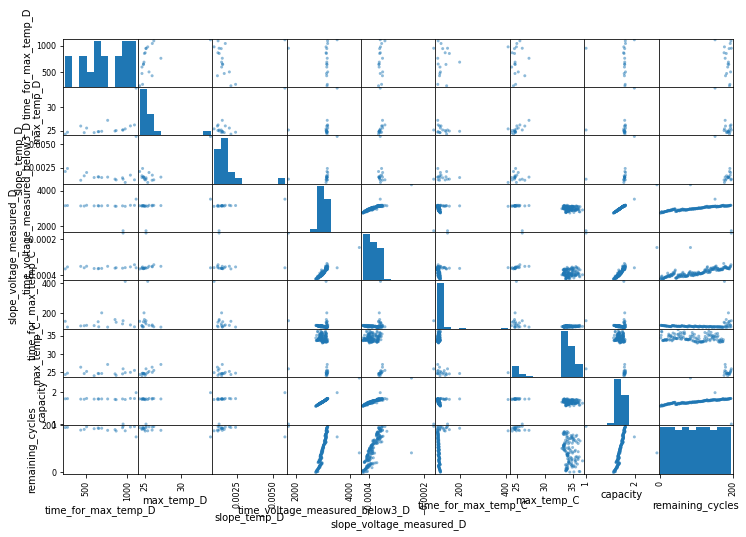

In [18]:
from pandas.plotting import scatter_matrix

attributes = df.columns
scatter_matrix(df[attributes], figsize=(12,8))
plt.show()

In [ ]:
tools.cycle_plotter(new_cycles, discharge_indices)

In [8]:
tools.get_indices(new_cycles, is_charge=False)

NameError: name 'new_cycles' is not defined